# Attribute

**Direct Reference**: pinn_ode_tutorial-master github repositor

**Original Work**: *Renato Nascimento, Kajetan Fricke, Felipe Viana*
**Reference Github repo** https://github.com/PML-UCF/pinn_ode_tutorial.git

# Libraries and Dependencies

In [180]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as matplotlib

from torch.nn.parameter import Parameter
from torch import (
    linalg,
    nn,
    Tensor,
    stack,
    cat,
    transpose, 
    optim,
    zeros,
    diag,
    reshape,
    rand
    )

#For Data Generation
from scipy import signal
from scipy import linalg as linalg2

### Statespace Function

In [181]:
#Generate a SDOF MSDS using a statespace function
def statespacegenerator(m,c,k,T,dt,x0):
    #System input force in Newtons
    F_train = np.zeros((int(T/dt)))
    j = 0
    for i in range (0,int(T/dt)):
        F_train[[i]] = 0#*(-0.5*np.exp(j*0.05)*np.sin(4*j)+2*np.exp(j*0.05)*np.cos(4*j))
        j = j+dt

    #State space model for a SDOF system
    #discretize the time steps 
    tdiscrete = np.arange(0,T,dt)

    A = [[0,1], [-k/m, -c/m]]
    B = [[0],[1/m]]
    C = [[1,0]]
    SDOFsys = signal.StateSpace(A,B,C,0)
    [timetrace, y, x] = signal.lsim(SDOFsys, F_train, tdiscrete, x0)

    return timetrace, y, x, F_train

### Synthesize Data

In [182]:
#Generate synthetic data fleshed out
x0 = np.array([1,0])
timestep = 1/3000
m = 1
c = 4
k = 400
timetotal = 1
[t,y,x,F] = statespacegenerator(m,c,k,timetotal,timestep,x0)
#Re-define 'xtrain' as the network input
noise = np.random.normal(0,1,y.shape)
state_noise = y + 0.1*noise

#sample for 30 evenly spaced data points
t_train = []
state_train = []
F_train = []
for idx in range(3000):
    if (idx)%100 == 0:
        t_train.append(t[idx])
        state_train.append(state_noise[idx])
        F_train.append(F[idx])
print('debug')

debug


# Hybrid RNN Code

### Construct / Deploy Hybrid RNN

In [183]:
class MyRNN(nn.Module):
    def __init__(self, cell, **kwargs):
        super(MyRNN, self).__init__()
        self.cell = cell

    def forward(self, inputs, initial_state):
        # Step into proceeding timestep
        bs, seq_sz = inputs.shape
        state = []
        state.append(initial_state)
        for t in range(1, seq_sz): 
            input = inputs[:, t-1]
            state_t = self.cell.forward(input, state[t-1])
            state.append(state[t-1]+state_t)

        return stack((state),dim=1)

### Construct Runge-Kutta Cell

In [184]:
class RungeKuttaIntegratorCell(nn.Module):
    def __init__(self, m, c, k, dt, **kwargs):
        super(RungeKuttaIntegratorCell, self).__init__(**kwargs)
        self.c = Parameter(c[0])
        self.k = Parameter(k[0])

        # Runge-Kutta iterative vectors
        self.state_size    = 2*len(m)
        self.A  = Tensor([0., 0.5, 0.5, 1.0])
        self.B  = Tensor([[1/6, 2/6, 2/6, 1/6]])
        self.dt = dt
    '''    
    @property
    def c(self):
        return 30*abs(self.c_param)

    @property
    def k(self):
        return 30*abs(self.k_param)
    '''
    def forward(self, inputs, states):
        y    = states[:,0:1] # IC position
        ydot = states[:,1:2] # IC velocity
        #Prepare Runge-Kutta computation
        yddoti = self._fun(m, self.k, self.c, inputs, y, ydot)
        yi     = y + self.A[0] * ydot * self.dt
        ydoti  = ydot + self.A[0] * yddoti * self.dt
        fn     = self._fun(m, self.k, self.c, inputs, yi, ydoti)
        #Perfom Runge-Kutta Computation
        for j in range(1,4):
            yn    = y + self.A[j] * ydot * self.dt
            ydotn = ydot + self.A[j] * yddoti * self.dt
            ydoti = cat([ydoti, ydotn], dim=0)
            fn    = cat([fn, self._fun(m, self.k, self.c, inputs, yn, ydotn)], dim=0)

        y    = linalg.matmul(self.B, ydoti) * self.dt
        ydot =  linalg.matmul(self.B, fn) * self.dt

        return cat(([y, ydot]), dim=-1)

    def _fun(self, m, k, c, u, y, ydot):
        return (u - c*ydot - k*y)


### Training Loop

In [185]:
def pinn_training_loop(n_epochs, optimizer, model, loss_fn, train, label, initial_state):
    mae = nn.L1Loss()
    losses = []
    cs = []
    ks = []
    for epoch in range(1, n_epochs + 1):
        #Forward pass
        output_train = model(train, initial_state)[:,:,0]
        loss_train = loss_fn(output_train, label)
        mae_train = mae(output_train, label)
        #Partial observation
        #loss_train = loss_fn(output_train[:,:,0], label)
        #mae_train = mae(output_train[:,:,0], label)
        #Track loss and c, k changes
        losses.append(loss_train.item())
        cs.append(c.item())
        ks.append(k.item())
        #Backward pass
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        print(f"Epoch {epoch}, Training loss {loss_train.item():.4e}, mae {mae_train.item():.4e}")
        
    return losses, cs, ks

### Execute Training

In [186]:
# masses, spring coefficients, and damping coefficients
m = Tensor([1])
k = 1000*rand(1) # inintial guess for stiffness coefficient
c = 10*rand(1) # initial guess for damping coefficient
print(c)
print(k)
# data, prepare as tensors
dt_train = (t_train[1] - t_train[0])
t_train_tense = Tensor(t_train)
utrain = Tensor(F_train)
ytrain = Tensor(state_train)

t_tense = Tensor(t)
F_tense = Tensor(F)
y_tense = Tensor(y)

#resize tensors
#t_train_tense = reshape(t,(1,len(t)))
utrain = reshape(utrain, (1, len(t_train)))
ytrain = reshape(ytrain, (1, len(t_train)))

#tpuretense = reshape(tpuretense, (1,len(tpuretense)))
F_full = reshape(F_tense, (1, len(t)))
y_full = reshape(y_tense, (1, len(t)))

#utrain = ufull[:,0:251,:]
#ytrain = yfull[:,0:251,:]
#t_trains = t[0:251,:]

# Initial state of the system 
initial_state = Tensor(x0)
initial_state = reshape(initial_state,(1,2))

rkCell = RungeKuttaIntegratorCell(m=m, c=c, k=k, dt=dt_train)
model = MyRNN(cell=rkCell)
    
#prediction results before training
yPred_before = model(utrain, initial_state)
yPred_before = yPred_before.detach().numpy()[0,:,0]

#check number of params
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

#PINN training
losses, cs, ks = pinn_training_loop(
        n_epochs = 10000,
        optimizer = optim.Adam(model.parameters(), lr=5e-2),
        model = model,
        loss_fn = nn.MSELoss(),
        train = utrain,
        label = ytrain,
        initial_state=initial_state
        )
#print("debug stopper")


tensor([8.4456])
tensor([827.7227])
2
Epoch 1, Training loss 1.9549e-01, mae 3.3590e-01
Epoch 2, Training loss 1.9410e-01, mae 3.3451e-01
Epoch 3, Training loss 1.9274e-01, mae 3.3322e-01
Epoch 4, Training loss 1.9142e-01, mae 3.3195e-01
Epoch 5, Training loss 1.9012e-01, mae 3.3070e-01
Epoch 6, Training loss 1.8886e-01, mae 3.2947e-01
Epoch 7, Training loss 1.8762e-01, mae 3.2826e-01
Epoch 8, Training loss 1.8642e-01, mae 3.2720e-01
Epoch 9, Training loss 1.8524e-01, mae 3.2630e-01
Epoch 10, Training loss 1.8409e-01, mae 3.2552e-01
Epoch 11, Training loss 1.8297e-01, mae 3.2475e-01
Epoch 12, Training loss 1.8187e-01, mae 3.2400e-01
Epoch 13, Training loss 1.8080e-01, mae 3.2326e-01
Epoch 14, Training loss 1.7976e-01, mae 3.2253e-01
Epoch 15, Training loss 1.7874e-01, mae 3.2181e-01
Epoch 16, Training loss 1.7775e-01, mae 3.2111e-01
Epoch 17, Training loss 1.7678e-01, mae 3.2042e-01
Epoch 18, Training loss 1.7583e-01, mae 3.1973e-01
Epoch 19, Training loss 1.7490e-01, mae 3.1907e-01
Ep

### Visualize Results

tensor([4.2658])
tensor([358.3879])


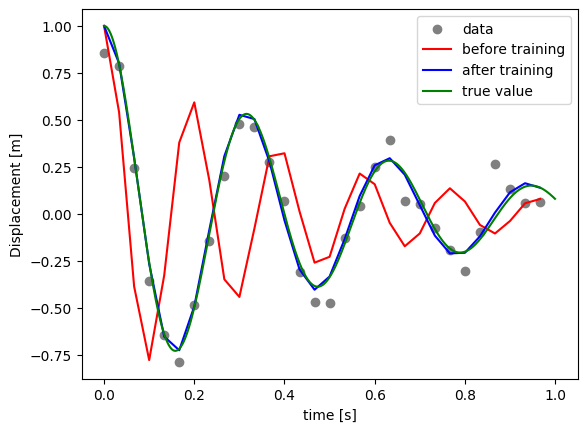

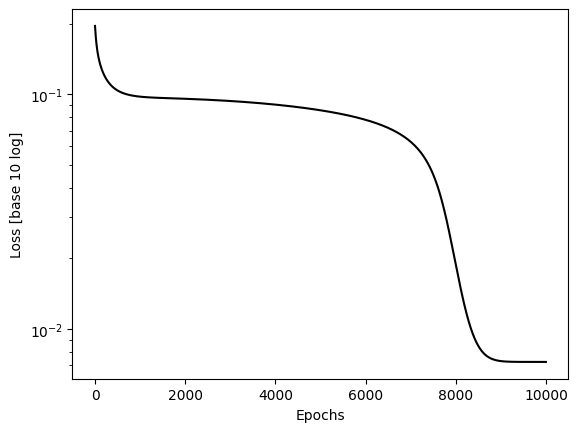

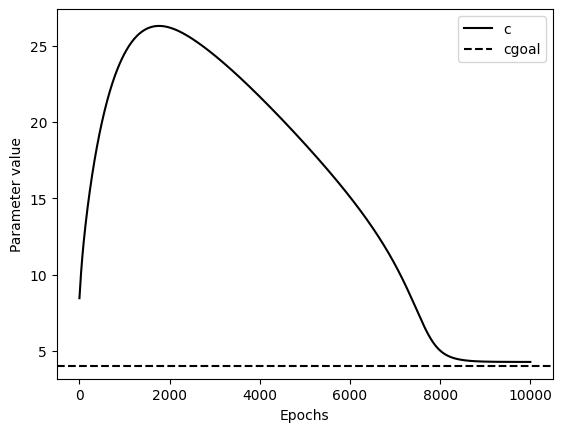

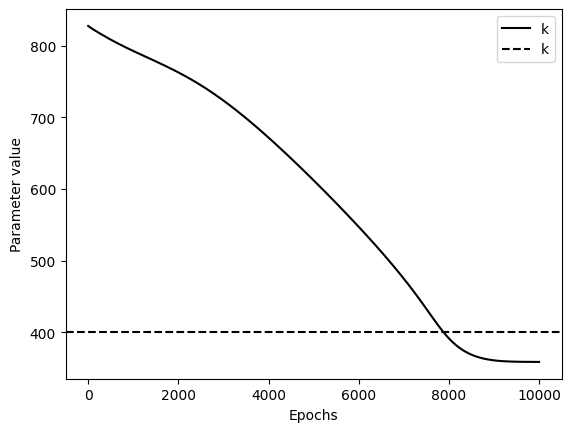

In [189]:
#prediction results after training
yPred = model(utrain, initial_state)
yPred = yPred.detach().numpy()[0,:,0]

# plotting prediction results
print(c)
print(k)
# prep for scatterplot

plt.scatter(t_train, state_train, color = 'gray', label = 'data')
plt.plot(t_train, yPred_before, 'r', label='before training')
plt.plot(t_train, yPred, 'b', label='after training')
plt.plot(t, y, 'g', label = 'true value')
plt.xlabel('time [s]')
plt.ylabel('Displacement [m]')
plt.legend()
plt.show()

# Loss
plt.plot(losses,color = 'black')
plt.yscale("log")
plt.xlabel('Epochs')
plt.ylabel('Loss [base 10 log]')
plt.show()

#C track
plt.plot(cs[0:], color = 'black', label = 'c')
plt.axhline(y = 4, color = 'black', linestyle = 'dashed', label = 'cgoal')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Parameter value')
#plt.ylim([0,10])
plt.show()

#k track
plt.plot(ks[0:], color = 'black', label = 'k')
plt.axhline(y = 400, color = 'black', linestyle = 'dashed', label = 'k')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Parameter value')
#plt.ylim([0,1000])
plt.show()